
Fit a gradient boosted decision tree (using the efficient implementation in HistGradientBoostingRegressor) to predict the taxi fare using all the features except pickup and dropoff times and pickup and dropoff boroughs. Use an 80/20 train-test split.


In [1]:
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
taxis_df = sns.load_dataset('taxis')

In [5]:
taxis_df.head(2)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan


In [3]:
model_data = taxis_df[['passengers', 'distance', 'color', 'payment', 'pickup_zone', 'dropoff_zone', 'fare']]
X = model_data[['passengers', 'distance', 'color', 'payment', 'pickup_zone', 'dropoff_zone']]
y = model_data['fare']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=211, test_size=0.2)

model = HistGradientBoostingRegressor(
    categorical_features = model_data.columns[model_data.dtypes == 'object']
)
model.fit(X_train,y_train)

HistGradientBoostingRegressor(categorical_features=Index(['color', 'payment', 'pickup_zone', 'dropoff_zone'], dtype='object'))

In [6]:
from sklearn.metrics import mean_squared_error
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Train MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_pred)}')

Train MSE: 9.023940752748997
Test MSE: 20.40873606968368



The model performs significantly better on the training data (MSE = 9.02) compared to the test data (MSE = 20.41), indicating potential overfitting.

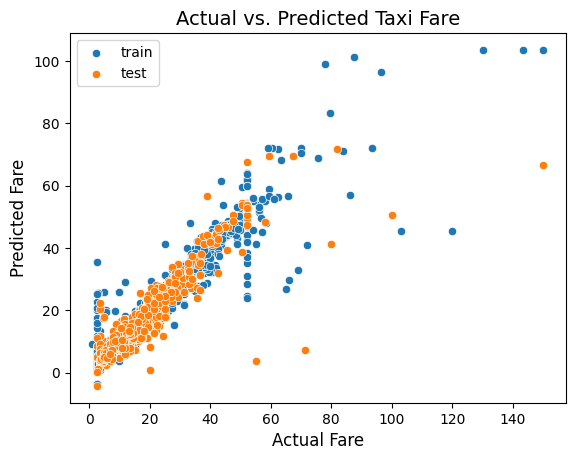

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=y_train, y=y_train_pred, label='train')
sns.scatterplot(x=y_test, y=y_test_pred, label='test')

plt.xlabel('Actual Fare', fontsize=12)
plt.ylabel('Predicted Fare', fontsize=12)

plt.title('Actual vs. Predicted Taxi Fare', fontsize=14)

plt.legend()

Key Takeaways: The plot shows that the model predicts well for lower fares in both the training and test sets, with a strong correlation between actual and predicted values. However, for higher fares, the model's predictions are less accurate, particularly on the test data, indicating possible overfitting. So  further tuning might be needed for higher fare predictions (x > 60). Adding more data or assigning special weights to higher fare cases could improve the model's performance in those areas.

## Hyperparameter search <br>
This model has a large number of hyperparameters which can affect its training performance. We're going to use a cross-validated random search over the three of them to try to find optimal values. <br>

- Use appropriate distributions from scipy.stats to set up the param_distributions
- Run the randomized search CV (this takes a while, if it's running for too long, decrease the n_iter)
- Create a dataframe to store the results
- Find the best-performing set of hyperparameters. What are they? How much better does the model perform with these hyperparameters? How can this information help you improve how you set up the hyperparameter search?

In [8]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

param_destributions = {
      # For max_depth, use a distribution that produces integers
    'max_depth': scipy.stats.randint(1, 1000),
    # For max_iter, use a distribution that produces integers
    'max_iter': scipy.stats.randint(1, 1000),
    # For learning rate, use a continuous distribution that produces numbers which are not evenly linearly spaced
    'learning_rate': scipy.stats.loguniform(0.01, 1),
}

search_cv = RandomizedSearchCV(
    HistGradientBoostingRegressor(categorical_features = model_data.columns[model_data.dtypes == 'object']),
    param_distributions=param_destributions,
    n_iter= 20,
    random_state= 211,
    n_jobs= 8,
    # Specify the appropriate scoring function for mean squared error
    scoring = 'neg_mean_squared_error'
)

search_cv.fit(X_train, y_train)

RandomizedSearchCV(estimator=HistGradientBoostingRegressor(categorical_features=Index(['color', 'payment', 'pickup_zone', 'dropoff_zone'], dtype='object')),
                   n_iter=20, n_jobs=8,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd4a2d65b40>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bd4a2d65de0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bd4a2d67f10>},
                   random_state=211, scoring='neg_mean_squared_error')

In [9]:
import pandas as pd
results_df = pd.DataFrame(
    search_cv.cv_results_
)
results_df.sort_values('mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1.321750,0.206520,0.196493,0.047002,0.029373,555,18,"{'learning_rate': 0.029373272949601327, 'max_d...",-61.292433,-57.994514,-69.763924,-47.124933,-63.371680,-59.909497,7.458166,20
8,0.681430,0.055969,0.100322,0.015663,0.036504,752,19,"{'learning_rate': 0.03650354668773165, 'max_de...",-49.336316,-45.475613,-59.061565,-36.923941,-51.417649,-48.443017,7.264910,19
18,4.422301,0.715174,0.328403,0.109442,0.944861,600,147,"{'learning_rate': 0.944861224620332, 'max_dept...",-24.394077,-17.347961,-30.523486,-20.546284,-28.998541,-24.362070,4.964250,18
1,5.910822,0.859179,0.441162,0.164336,0.869597,811,204,"{'learning_rate': 0.869596815155094, 'max_dept...",-24.411305,-18.587968,-32.123361,-18.049043,-27.078971,-24.050129,5.297729,17
2,14.183553,1.204861,0.879256,0.389078,0.912272,927,490,"{'learning_rate': 0.9122720764656406, 'max_dep...",-24.203427,-22.590388,-27.737131,-19.897860,-25.480053,-23.981772,2.646166,16
3,6.129125,0.499396,0.754406,0.034181,0.847587,816,218,"{'learning_rate': 0.847586989253268, 'max_dept...",-22.001062,-21.272752,-32.030018,-18.784846,-24.880407,-23.793817,4.553575,15
12,17.165270,0.687743,1.388369,0.159772,0.725919,117,616,"{'learning_rate': 0.7259194180808346, 'max_dep...",-25.435967,-17.727478,-28.276733,-21.341265,-23.001138,-23.156516,3.583469,14
7,3.330516,0.947872,0.205896,0.058523,0.026643,671,68,"{'learning_rate': 0.02664261926446039, 'max_de...",-24.232177,-16.933590,-34.399574,-15.052767,-23.375044,-22.798630,6.802445,13
15,18.480779,0.677312,1.176628,0.259012,0.615343,484,628,"{'learning_rate': 0.6153429809352972, 'max_dep...",-26.763851,-18.664052,-26.494310,-17.820578,-23.865055,-22.721569,3.804322,12
17,12.520371,0.710836,1.086002,0.101885,0.539454,858,468,"{'learning_rate': 0.5394542926598631, 'max_dep...",-24.483539,-17.896692,-29.070751,-18.021554,-21.424859,-22.179479,4.218966,11


In [ ]:
mse_improvement = (20.40-18.26)/20.40

The best model has a test MSE of 18.26, which is a 10% improvement over the original specification. This model uses a learning rate of 0.064, a max depth of 431, and max_iter of 474.
These hyperparameters are within the middle range of the search space (1–1000), suggesting that the current search space is reasonable. Expanding the search space further may not yield significant improvements.
Instead, future efforts could focus on fine-tuning smaller ranges or adjusting other parameters to further improve performance.